In [2]:
%%writefile models.py
import edward as ed
import edward.models as edm
import tensorflow as tf
import numpy as np
import pymisca.numpy_extra as pynp

class BaseModel(object):
    def __init__(self,name='test'):
        self.name = name
        print type(self),self.__dict__
        pass
    def sanitise(self,X):
        X  = np.asarray(X,np.float32)        
        return X
    def fit(self,X):
        X = self.sanitise(X)
        self._fit(X)
        pass
    
    def predict_proba(self,X,norm = 1,log=1):
        X = self.sanitise(X)
        prob = self._predict_proba(X)
        if norm:
            prob = prob - pynp.logsumexp( prob, axis =1,keepdims=1)
        if not log:
            prob = np.exp(log)
        return prob
    def score(self,X,keepdims=0):
        prob = self.predict_proba(X,norm=0,log=1)
        score = pynp.logsumexp( prob, axis =1,keepdims=keepdims)
        return score
    
    def predict(self,X):
        proba = self.predict_proba(X,norm = 0)
        clu = np.argmax(proba,axis = 1)
        return clu
    
    def expand_input(self,X):
        N = len(X)
        X_bdc = tf.tile(
            tf.reshape(
                X, [N, 1, 1, self.D]),
                   [1, 1, self.K, 1])
        return X_bdc
    
    
class ModelA(BaseModel):
    def __init__(self,):
        super(ModelA,self).__init__()
        print self,self.__dict__
        pass
    def fit(self,X):
        pass
m = ModelA()
m.fit(1)# from models import *




class GMM_VIMAP(BaseModel):
    def __init__(self,D=None,K=20,*args,**kwargs):
        super(GMM_VIMAP,self).__init__(*args,**kwargs)
        self.K = K
        self.D = D
        self.N_post = None
        self.emission = None
        self.prior = None
        if D is not None:
            self.init_param(D=D)    
        
        print self,self.__dict__
#         pass
    def init_param(self,D=None,K = None,
#                    N=None
                  ):
        self.D = D = self.D if D is None else D
        assert D is not None
        self.K = K = self.K if K is None else K
        assert K is not None
  
        self.pi = edm.Dirichlet(tf.ones(K))
    
        self.mu = edm.Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
        self.sigmasq = edm.InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
#         name = self.name if self.'test'
        name = self.name

        try:
            tf.get_variable(name+'/test',[1])
            reuse = None
        except:
            reuse = True
        print reuse
        
        with tf.variable_scope(name, reuse=reuse):
            self.qmu = ed.models.PointMass(
            tf.get_variable("qmu", [K,D])
        )
            self.qsig = ed.models.PointMass(
            tf.nn.softplus(tf.get_variable("qsig", [K,D]))
        )
            self.q_pi = ed.models.PointMass(
                tf.nn.softmax(
                    tf.get_variable("q_pi", [K])
                )
            )
        self.pDict = {self.mu: self.qmu, self.sigmasq: self.qsig,
                      self.pi:self.q_pi}        
        
        return self
    @property
    def means_(self):
        res = self.qmu.eval()
        return res
    @property
    def covariances_(self):
        res = map(np.diag,self.qsig.eval())
        return res
    @property
    def weights_(self):
        res = self.q_pi.eval()
        return res    
    def _fit(self,X):
        X  = np.asarray(X,np.float32)        
        K = self.K
        N = len(X)
        
        self.cat = edm.Categorical(probs=self.pi, sample_shape=N)
        self.components = [
            edm.MultivariateNormalDiag(
                self.mu[k],
                tf.sqrt(self.sigmasq[k]
                                          ), sample_shape=N)
            for k in range(K)]
        self.emission = edm.Mixture(
            cat=self.cat, 
            components=self.components,
            sample_shape=N)
        
        self.dDict = {self.emission: X}
        self.inference = ed.MAP(self.pDict,self.dDict)
        self.inference.run(n_iter=500, n_print=100, )
        return self
    
    
    def _predict_proba(self,X, N=None, norm = 0):
        ''' self.emission does not work, manually build posterior
'''
        if X is None:
            assert N is not None
        else:
            N = len(X)
        if not self.N_post is N:        
            ones = tf.ones([N, 1, 1, 1])
            self.x_post = em = edm.Normal(
                    loc = ones * self.qmu,
                  scale = ones * self.qsig)
            self.N_post = N
        #     _make_posterior(self,X=X)
#         self._make_posterior(X=X)
        N = len(X)
        #### (num_sample, num_post, num_component, dimensionality)
        X_bdc = tf.tile(
            tf.reshape(
                X, [N, 1, 1, self.D]),
                   [1, 1, self.K, 1])

        X_loglik = ll = self.x_post.log_prob(X_bdc)
        ll = tf.reduce_mean(ll,axis=1)  ### over posterior samples
        ll = tf.reduce_sum(ll,axis=-1)  ### over dimensions
        logP = ll.eval()
        return logP
    
#     def predict(self,X):
#         logP = self.predict_proba(X)
#         clu  = logP.argmax(axis=1)
#         return clu# name = 'test6'
# reload(mym)
# from models import *
class GMMLRP_VIMAP(BaseModel):
#     self.emDist = edm.MultivariateNormalDiagPlusLowRank    
    emDist = edm.MultivariateNormalDiagPlusLowRank    
    def __init__(self,D=None,K=20,
                 *args,**kwargs):
        super(GMMLRP_VIMAP,self).__init__(*args,**kwargs)
        self.K = K
        self.D = D
        self.initialised = False
        if D is not None:
            self.init_model(D=D)   
        
            
    def init_model(self,D=None,K = None,alpha = 1.0):
        self.D = D = self.D if D is None else D
        assert D is not None
        self.K = K = self.K if K is None else K
        assert K is not None
        name = self.name
        try:
            tf.get_variable(name+'/test',[1])
            reuse = None
        except:
            reuse = True
        print reuse
        with tf.variable_scope(name, reuse=reuse):
            
            ##### Prior
            mu = edm.Normal(tf.zeros(D), tf.ones(D), sample_shape=K)            
            scale_diag =  edm.Uniform(sample_shape=(K,D))
            scale_perturb_factor =  edm.Uniform(sample_shape=(K,D,1))            
#             scale_perturb_factor = edm.Normal(
#                     loc=tf.zeros(1),
#                     scale=tf.ones(1),
#                     sample_shape=(K,D)
#                 )
            
#             self.pi = edm.Dirichlet(tf.ones(K))
            self.pi = pi = edm.Dirichlet( float(alpha)/K * tf.ones(K) )
            
        
            ##### Posterior
            self.q_pi = ed.models.PointMass(
                tf.nn.softmax(
                    tf.get_variable("q_pi", [K])
                )
            )
            self.q_mu = ed.models.PointMass(
                tf.get_variable("q_mu", [K,D])
            )
            self.q_scale_diag  = edm.PointMass(
                tf.nn.softplus(
                    tf.get_variable('q_scale_diag',shape=[K,D])
                              ),
            )
            self.q_scale_perturb_factor = ed.models.PointMass(
                (
                    tf.get_variable("q_scale_perturb_factor", [K,D,1])
                )
            )
            
    
        ##### Dictonary for constructing self.emDist(**self.param)
        self.param = {'loc':(mu,
                             self.q_mu),
                     'scale_diag':(scale_diag,
                                   self.q_scale_diag),
                     'scale_perturb_factor':(scale_perturb_factor,
                                             self.q_scale_perturb_factor
                                             ),
                     'weight':(self.pi,
                               self.q_pi),
                     }
        self.emKey = ['loc','scale_diag','scale_perturb_factor']
        self.priorDict = {v[0]:v[1] for v in self.param.values()}
#         self.priorDict.update({self.pi:self.q_pi})
        
        self.postDict = {k:v[1] for k,v in self.param.items()}
        
        ### Prior components
        cDicts = [
            {key:v[0][k] 
             for key,v in self.param.items() 
             if key in self.emKey} 
            for k in range(K)]
        self.components = [self.emDist(**d) for d in cDicts]
        
        ### Posterior generative
        self.x_post = em = self.emDist(**{k:v for k,v in self.postDict.items()
                                         if k in self.emKey})

        self.initialised = True; return self
            
    def _fit(self,X,n_iter=1000, n_print=100, **kwargs):
#         X  = np.asarray(X,np.float32)        
        K = self.K
        N = len(X)

        self.cat = edm.Categorical(probs=self.pi, 
                                   sample_shape=N
                                  )
        self.emission = edm.Mixture(
            cat=self.cat, 
            components=self.components,
            sample_shape=N
        )
        
        
        
        print ('hiModel')
        self.dDict = {self.emission: X}
        self.inference = ed.MAP(self.priorDict,self.dDict)
        self.inference.run(n_iter = n_iter, n_print=n_print,*kwargs)
        return self
    
    @property
    def means_(self):
        res = self.x_post.mean().eval()
        return res
    @property
    def covariances_(self):
        res = self.x_post.covariance().eval()
        return res
    @property
    def weights_(self):
        res = self.q_pi.eval()
        return res
    def _predict_proba(self,X, N=None, norm = 0):
        ''' self.emission does not work, manually build posterior
'''
        
        N = len(X)
        X_bdc = self.expand_input(X)
        # em.log_prob(X_bdc).eval()
        X_loglik = ll = self.x_post.log_prob(X_bdc)
        ll = tf.reduce_mean(ll,axis=1)  ### over posterior samples
    #     ll = tf.reduce_sum(ll,axis=-1)  ### over dimensions
        logP = ll.eval()   
        return logP
    
class GLRP_VIMAP(BaseModel):
#     self.emDist = edm.MultivariateNormalDiagPlusLowRank    
    emDist = edm.MultivariateNormalDiagPlusLowRank    
    def __init__(self,D=None,K=20,
                 *args,**kwargs):
        super(GMMLRP_VIMAP,self).__init__(*args,**kwargs)
        self.K = K
        self.D = D
        self.initialised = False
        if D is not None:
            self.init_model(D=D)   
        
            
    def init_model(self,D=None,K = None,alpha = 1.0):
        self.D = D = self.D if D is None else D
        assert D is not None
        self.K = K = self.K if K is None else K
        assert K is not None
        name = self.name
        try:
            tf.get_variable(name+'/test',[1])
            reuse = None
        except:
            reuse = True
        print reuse
        with tf.variable_scope(name, reuse=reuse):
            
            ##### Prior
            mu = edm.Normal(tf.zeros(D), tf.ones(D), sample_shape=K)            
            scale_diag =  edm.Uniform(sample_shape=(K,D))
            scale_perturb_factor =  edm.Uniform(sample_shape=(K,D,1))            
#             scale_perturb_factor = edm.Normal(
#                     loc=tf.zeros(1),
#                     scale=tf.ones(1),
#                     sample_shape=(K,D)
#                 )
            
#             self.pi = edm.Dirichlet(tf.ones(K))
#             self.pi = pi = edm.Dirichlet( float(alpha)/K * tf.ones(K) )
            
        
            ##### Posterior
            self.q_pi = ed.models.PointMass(
                tf.nn.softmax(
                    tf.get_variable("q_pi", [K])
                )
            )
            self.q_mu = ed.models.PointMass(
                tf.get_variable("q_mu", [K,D])
            )
            self.q_scale_diag  = edm.PointMass(
                tf.nn.softplus(
                    tf.get_variable('q_scale_diag',shape=[K,D])
                              ),
            )
            self.q_scale_perturb_factor = ed.models.PointMass(
                (
                    tf.get_variable("q_scale_perturb_factor", [K,D,1])
                )
            )
            
    
        ##### Dictonary for constructing self.emDist(**self.param)
        self.param = {'loc':(mu,
                             self.q_mu),
                     'scale_diag':(scale_diag,
                                   self.q_scale_diag),
                     'scale_perturb_factor':(scale_perturb_factor,
                                             self.q_scale_perturb_factor
                                             ),
                     'weight':(self.pi,
                               self.q_pi),
                     }
        self.emKey = ['loc','scale_diag','scale_perturb_factor']
        self.priorDict = {v[0]:v[1] for v in self.param.values()}
#         self.priorDict.update({self.pi:self.q_pi})
        
        self.postDict = {k:v[1] for k,v in self.param.items()}
        
        ### Prior components
        cDicts = [
            {key:v[0][k] 
             for key,v in self.param.items() 
             if key in self.emKey} 
            for k in range(K)]
        self.components = [self.emDist(**d) for d in cDicts]
        
        ### Posterior generative
        self.x_post = em = self.emDist(**{k:v for k,v in self.postDict.items()
                                         if k in self.emKey})

        self.initialised = True; return self
            
    def _fit(self,X,n_iter=1000, n_print=100, **kwargs):
#         X  = np.asarray(X,np.float32)        
        K = self.K
        N = len(X)

        self.cat = edm.Categorical(probs=self.pi, 
                                   sample_shape=N
                                  )
        self.emission = edm.Mixture(
            cat=self.cat, 
            components=self.components,
            sample_shape=N
        )
        
        
        
        print ('hiModel')
        self.dDict = {self.emission: X}
        self.inference = ed.MAP(self.priorDict,self.dDict)
        self.inference.run(n_iter = n_iter, n_print=n_print,*kwargs)
        return self
    
    @property
    def means_(self):
        res = self.x_post.mean().eval()
        return res
    @property
    def covariances_(self):
        res = self.x_post.covariance().eval()
        return res
    @property
    def weights_(self):
        res = self.q_pi.eval()
        return res
    def _predict_proba(self,X, N=None, norm = 0):
        ''' self.emission does not work, manually build posterior
'''
        
        N = len(X)
        X_bdc = self.expand_input(X)
        # em.log_prob(X_bdc).eval()
        X_loglik = ll = self.x_post.log_prob(X_bdc)
        ll = tf.reduce_mean(ll,axis=1)  ### over posterior samples
    #     ll = tf.reduce_sum(ll,axis=-1)  ### over dimensions
        logP = ll.eval()   
        return logP

# i += 1

Overwriting models.py


Overwriting tutil.py


/home/shouldsee/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<class 'models.ModelA'> {'name': 'test'}
<models.ModelA object at 0x7f39c0866350> {'name': 'test'}
<class 'models.ModelA'> {'name': 'test'}
<models.ModelA object at 0x7f397d68eb50> {'name': 'test'}
is in ipython: 1
is in ipython: 1
[WARN] pymisca.vis_util cannot find network
is in ipython: 1
[WARN] pymisca.vis_util cannot find network
<class 'models.ModelA'> {'name': 'test'}
<models.ModelA object at 0x7f3976b17ad0> {'name': 'test'}
is in ipython: 1
[WARN] pymisca.vis_util cannot find network
<class 'models.ModelA'> {'name': 'test'}
<models.ModelA object at 0x7f3976b17c50> {'name': 'test'}
is in ipython: 1
[WARN] pymisca.vis_util cannot find network
<class 'models.GMM_VIMAP'> {'name': 'test'}
None
<models.GMM_VIMAP object at 0x7f3977221ed0> {'pDict': {<ed.RandomVariable 'Normal/' shape=(20, 2) dtype=float32>: <ed.RandomVariable 'test/PointMass/' shape=(20, 2) dtype=float32>, <ed.RandomVariable 'InverseGamma/' shape=(20, 2) dtype=float32>: <ed.RandomVariable 'test/PointMass_1/' shape=(20

/home/shouldsee/.local/lib/python2.7/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 10s | Loss: 219.420
[0.9999105, 4.0939998e-05, 4.010391e-05, 4.8574007e-06, 8.946562e-07, 8.2632397e-07, 3.4247287e-07, 2.8062504e-07, 2.2827584e-07, 2.1725823e-07, 1.6201203e-07, 1.4813054e-07, 1.439697e-07, 8.896766e-08, 7.9765464e-08, 6.763541e-08, 6.468629e-08, 6.323051e-08, 5.8037195e-08, 5.800333e-08]
[0.4871155  0.50154537] [[0.08886529 0.        ]
 [0.         0.08727986]] 1499
[0.00680767 0.00653076] [[0.4995978  0.        ]
 [0.         0.49958977]] 1
[0.00655678 0.00535373] [[0.4995998  0.        ]
 [0.         0.49961147]] 1
[-0.00746494 -1.37601677] [[ 0.30329359 -0.08297725]
 [-0.08297725  0.07976522]] 500
[1.7363696 1.6911748] [[ 0.09822492 -0.05986782]
 [-0.05986782  0.10374456]] 500
[2.48052727 1.95671187] [[ 0.20592909 -0.00814436]
 [-0.00814436  0.07626837]] 500
<class 'models.GMM_VIMAP'> {'name': 'testB'}
None
<models.GMM_VIMAP object at 0x7f3947cf9f50> {'pDict': {<ed.RandomVariable 'Normal_42/' shape=(3, 2) dty

UnboundLocalError: local variable 'has_low_rank' referenced before assignment

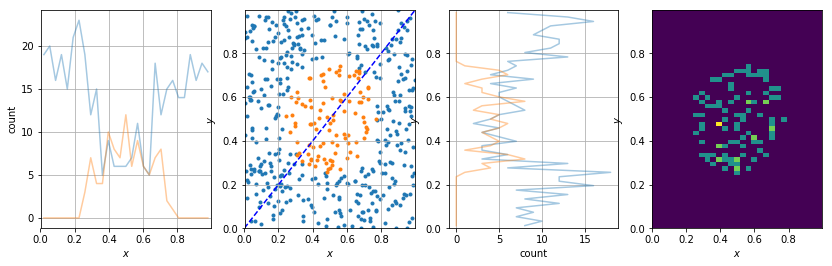

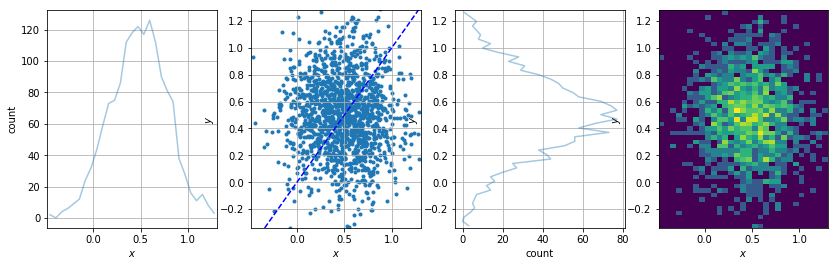

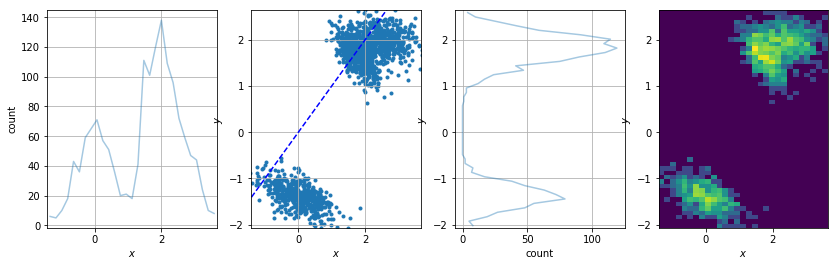

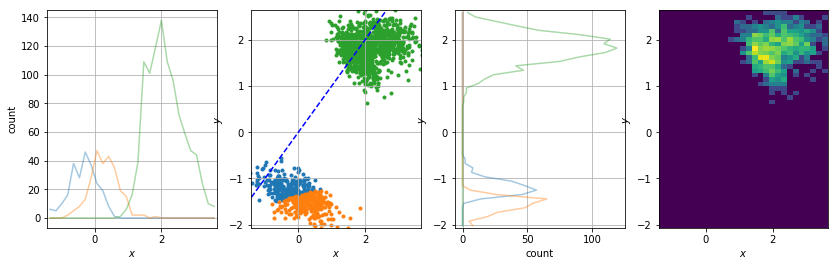

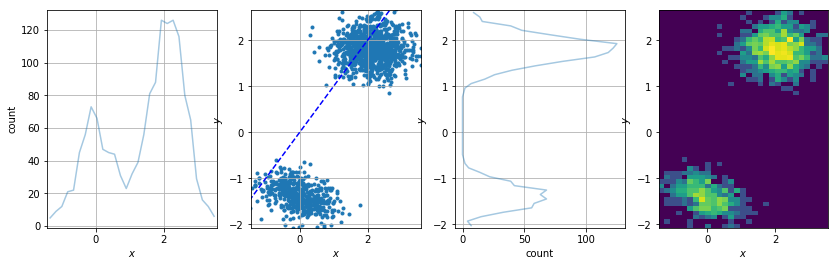

In [1]:
%%time
execfile('test__gmm.py')
# !python test__gmm.py

In [13]:
m.weights_

array([0.311736  , 0.3549307 , 0.33333337], dtype=float32)

In [102]:
# dp.sample(10).sample(10)

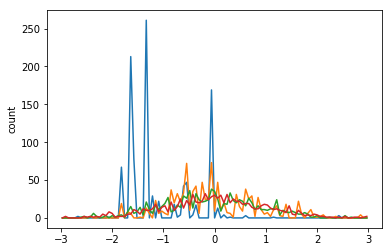

In [37]:
xbin = np.linspace(-3,3,100)
for conc in [5., 50., 500., 5000.]:
    dp = edm.DirichletProcess( conc, edm.Normal(loc=0.0, scale=1.0))
    X = dp.sample(1000).eval()
    pyvis.histoLine(X.ravel(),xbin )
# pyutil.plt.hist(X.eval().ravel(),xbin);


5
0


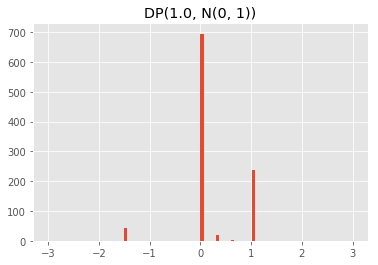

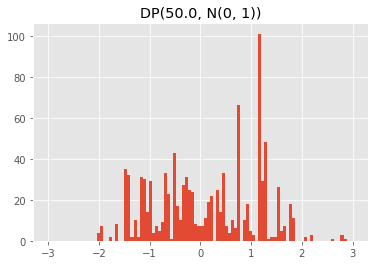

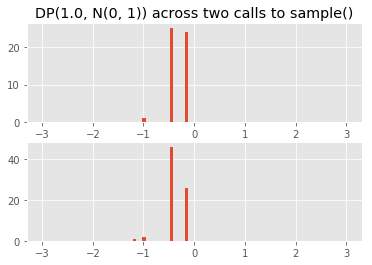

[0.026491458, 0.026491458]
[-0.098002076, -0.098002076]
RandomVariable("DirichletProcess_31/", shape=(3, 5, 2), dtype=int32)


SystemExit: 

In [41]:
# import exam
# edm
fname = '/home/shouldsee/repos/edward/examples/pp_dirichlet_process.py'
execfile(fname)

In [214]:
# D = K
# alpha = 1.0

pi = edm.Dirichlet( float(alpha)/K * tf.ones(D) )

<ed.RandomVariable 'Dirichlet_6/' shape=(8,) dtype=float32>

In [209]:
edm.Dirichlet??

In [206]:
edm.Dirichlet?

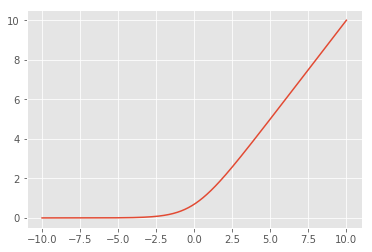

In [44]:
# tf.nn.softplus??
xs = np.linspace(-10,10,500)
ys = np.log(np.exp(xs)+1)
plt.plot(xs,ys)

In [49]:
from edward.models import *
# def fit_truncated_DPM():
if 1:
    #N = tf.placeholder(tf.int32)
    N = 500

    # Stick breaking representation of Dirichlet Process
    alpha = Gamma(1.0, 1.0)
    # Maximum number of sticks to break
    K = 4

    beta = Beta(tf.ones([K]), alpha * tf.ones([K]))
    probs = Deterministic(beta * tf.concat([[1], tf.cumprod(1.0 - beta)[:-1]], 0))

    sigma = InverseGamma(concentration=tf.ones([K, 1]), rate=tf.ones([K, 1]))
    mu = Normal(loc=tf.zeros([K, 1]), scale=tf.ones([K, 1]))
    alloc = Categorical(probs=tf.expand_dims(probs,0) * tf.ones([N, K]))

    mixture_mu = tf.squeeze(tf.gather(mu, alloc))
    mixture_sigma = tf.squeeze(tf.gather(sigma, alloc))

    y = Normal(loc=mixture_mu, scale=mixture_sigma)

    # Cavity Distributions
    qalpha = GammaWithSoftplusConcentrationRate(tf.Variable(1.0), tf.Variable(1.0))
    qbeta = Beta(tf.ones([K]), tf.nn.softplus(tf.Variable(tf.ones([K]))))
    qmu = NormalWithSoftplusScale(loc=tf.Variable(tf.zeros([K, 1])), scale=tf.Variable(tf.zeros([K, 1])))
    qsigma = InverseGammaWithSoftplusConcentrationRate(concentration=tf.Variable(tf.zeros([K, 1])), rate=tf.Variable(tf.zeros([K, 1])))
    qalloc = Categorical(probs=tf.nn.softmax(tf.Variable(tf.zeros([N, K]))))
    
# fit_truncated_DPM()


In [95]:
tsr = beta * tf.concat([[1], tf.cumprod(1.0 - beta)[:-1]], 0)
# tsr.shape
tsr.eval().sum()
# beta.shape
# tf.cumprod(1.0 - beta)[:-1]

0.7490824

In [81]:
# beta
if 1:
    beta = Beta(tf.ones([K]), alpha * tf.ones([K]))
    probs = Deterministic(beta * tf.concat([[1], tf.cumprod(1.0 - beta)[:-1]], 0),)
probs.shape
# beta.shape
# print probs.sample(1).eval()
print probs.sample(1).eval()

# probs.sample(1).eval()

[[0.3508459  0.1663838  0.19767022 0.0239534 ]]




* neural-clustering/examples/dpmm.py

https://github.com/edublancas/neural-clustering/blob/dad483b8165966c226d884f408816e4c18680e28/examples/dpmm.py

* Gaussian mixture with covariance matrix via klqp method

https://discourse.edwardlib.org/t/gaussian-mixture-with-covariance-matrix-via-klqp-method/277

* mean-field-advi-in-edward

https://discourse.edwardlib.org/t/mean-field-advi-in-edward/362/4

* mixture_gmm.ipynb by ecosang

https://github.com/ecosang/misc/blob/master/mixture_gmm.ipynb

* Variational Inference for Dirichlet Process Mixtures

https://discourse.edwardlib.org/t/variational-inference-for-dirichlet-process-mixtures/251/2

* DP in sklearn 

http://scikit-learn.org/stable/modules/mixture.html#the-dirichlet-process

书名    仿生嗅觉与味觉传感器（英文版）        

书号    978-7-03-045761-5/Q·3597        

In [14]:
import edward as ed
import edward.models as edm
import tensorflow as tf
import numpy as np
import pymisca.numpy_extra as pynp
